# Fine-tune a summarization model with labelled data and Hugging Face

In this tutorial, we'll use [Argilla](https://github.com/argilla-io/argilla) and [HuggingFace](https://huggingface.co/) to fine-tune a text summarization model with our own custom labelled dataset. It will walk you through the following steps:

-  📑 Load a dataset from the HuggingFace Hub and log it to Argilla to annotate. In this case, we'll use the [news summary](https://huggingface.co/datasets/argilla/news-summary-new) dataset.
- 🏷️ Explore and label the training dataset with Argilla to validate or modify.
- ⚙️ Load a summarization model from HuggingFace and fine-tune it with your labelled dataset. Here, we have chosen [T5-small](https://huggingface.co/t5-small), a lighter checkpoint of the powerful [T5 model](https://huggingface.co/t5-base) based on Transformer architecture.
- 🤗 Upload your model to your HuggingFace account to share it with the whole community.
- 🤖 Use your fine-tuned model for inference.

## Introduction

This tutorial is an easy introduction to the Argilla tool for data annotation and how to integrate it with HuggingFace smoothly in order to annotate data and fine-tune a text summarization model in just a few minutes. 

Summarization creates a shorter version of a document or an article that captures all the important information. Along with translation, it is another example of a task that can be formulated as a sequence-to-sequence task (more info [here](https://huggingface.co/docs/transformers/tasks/summarization#inference)).

Data labelling is crucial when training or fine-tuning machine learning models. Dataset quality is often disregarded, and this can have a negative impact on the model's performance. For text summarization, we need a dataset that features a source text and a target summary.

That is why Argilla comes to the rescue with its intuitive and user-friendly UI for data annotation and validation, so that we can make sure that we feed our model of choice with the best possible training data for the task at hand. Argilla helps to explore our summarization dataset, allowing us to validate or edit the summaries.

Let's get started!

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

1. [Deploy Argilla on Hugging Face Spaces](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla): This is the fastest option and the recommended choice for connecting to external notebooks (e.g., Google Colab) if you have an account on Hugging Face.

2. [Launch Argilla using Argilla's quickstart Docker image](../../getting_started/quickstart.ipynb): This is the recommended option if you want Argilla running on your local machine. Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup

For this tutorial, you'll need to install the Argilla client and a few third party libraries using `pip`:

In [ ]:
%pip install argilla INSERT_PACKAGE==INSERT_VERSION -qqq

In [ ]:
!pip install argilla

Let's import the Argilla module for reading and writing data:

In [ ]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="http://localhost:6900", 
    api_key="team.apikey"
)

Finally, let's include the imports we need:

In [ ]:
!pip install transformers datasets

## 1. Load a dataset from the HuggingFace Hub and log it to Argilla

First, we need a suitable dataset for news summarization. Since we want to fine-tune a model to summarize news articles, our ideal dataset will have no out-of-domain data that could degrade performance. Luckily for us, HuggingFace has an enormous repository full of potentially interesting datasets that can help us. We'll load the [news summary](https://huggingface.co/datasets/argilla/news-summary-new) dataset with the 'datasets' library, which has a column with the whole news articles aligned with another column that includes their summaries.

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("argilla/news-summary-new", split="train")

Just in case you want to take a look at the dataset. As we can see, the 'text' column displays the whole article, whereas the 'target' one is its summary.


In [ ]:
dataset[0]

{'text': 'WASHINGTON (Reuters) - U.S. President Donald Trump will begin a major push next week to convince the public of the need for tax reform, shifting his focus to fiscal policy in an effort to win a big legislative victory by the end of the year, The Financial Times reported on Friday. Trump would begin the effort next Wednesday with a speech in Missouri, the first in a series of addresses to generate public support on the issue, Gary Cohn, director of the National Economic Council, told the newspaper.  “We are completely engaged in tax reform,” Cohn told the FT in an interview. “Starting next week the president’s agenda and calendar is going to revolve around tax reform. He will start being on the road making major addresses justifying the reasoning for tax reform.” Although Cohn stressed that tax reform would be front and center of Trump’s agenda, the Republican-controlled Congress faces two other pressing issues when it returns from its August recess on Sept. 5.  Lawmakers need

Then, connect to your Argilla space to upload the dataset for annotation. To do so, we will init the Argilla client with our Space `URL` and `API_KEY` (no need to do this again if you've already runned it above):

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key

rg.init(
    api_url="http://localhost:6900", 
    api_key="team.apikey"
)

TIP: You can find your Space URL behind the Embed this space button

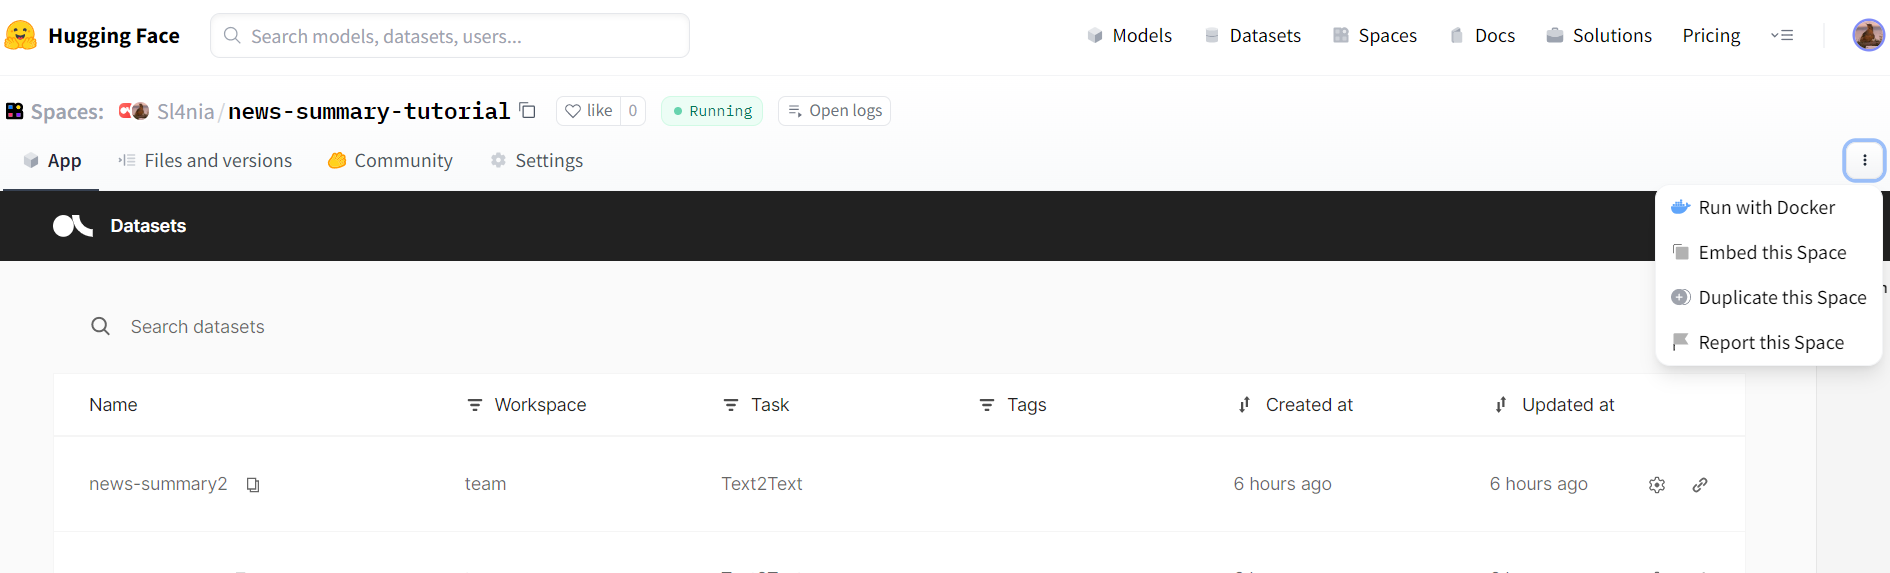

To extract the summaries into a new annotation column, we will write a quick helper function and map the whole dataset with it.

In [ ]:
def extract(row):
    return {"text": row["text"], "annotation": row["target"]}

dataset_for_training=dataset.map(extract)

Map:   0%|          | 0/114 [00:00<?, ? examples/s]

Have a quick look at the new dataset with the column for annotation:

In [ ]:
dataset_for_training[0]

{'text': 'WASHINGTON (Reuters) - U.S. President Donald Trump will begin a major push next week to convince the public of the need for tax reform, shifting his focus to fiscal policy in an effort to win a big legislative victory by the end of the year, The Financial Times reported on Friday. Trump would begin the effort next Wednesday with a speech in Missouri, the first in a series of addresses to generate public support on the issue, Gary Cohn, director of the National Economic Council, told the newspaper.  “We are completely engaged in tax reform,” Cohn told the FT in an interview. “Starting next week the president’s agenda and calendar is going to revolve around tax reform. He will start being on the road making major addresses justifying the reasoning for tax reform.” Although Cohn stressed that tax reform would be front and center of Trump’s agenda, the Republican-controlled Congress faces two other pressing issues when it returns from its August recess on Sept. 5.  Lawmakers need

We can now read this dataset with Argilla, which will automatically create the records and put them in an Argilla Dataset.

In [ ]:
dataset_rg = rg.read_datasets(dataset_for_training, task="Text2Text")

We will upload this dataset to the web app and give it the name 'news-summary2'.

In [ ]:
rg.log(dataset_rg, "news-summary2")

## 2. Explore and label the data

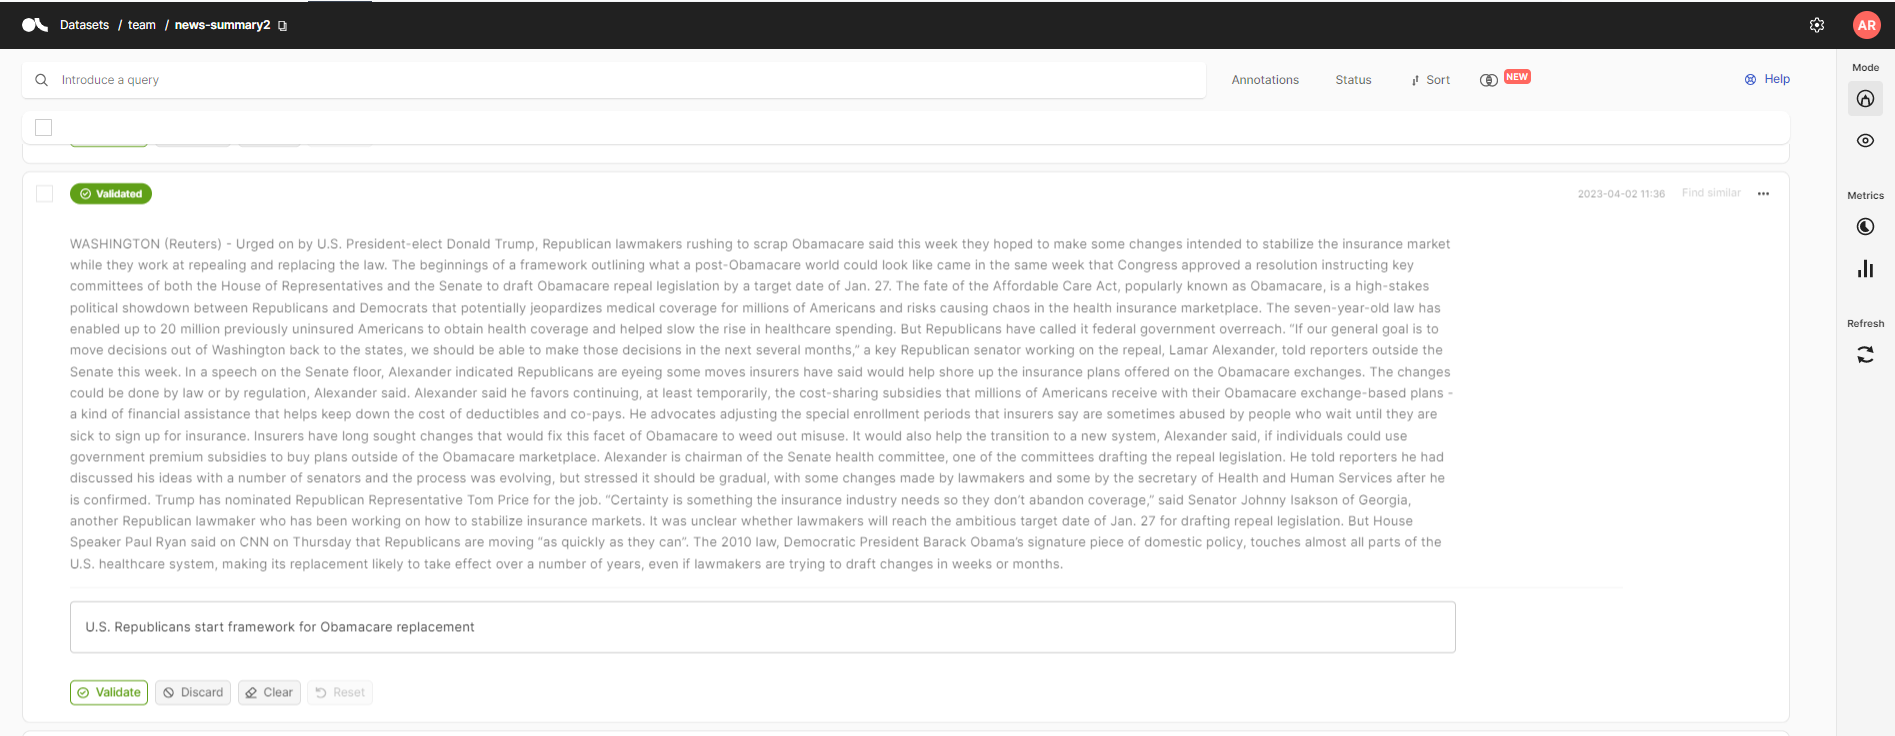

Now we can proceed to validate or edit the news articles summaries in order to control and improve the quality of the training data.

Once we've finished, we'll prepare the labelled dataset for model training using Argilla's method to automatically extract training examples in a suitable format from a dataset.

In [ ]:
training_data = rg.load("news-summary2").to_datasets()

In [ ]:
dataset = rg.load("news-summary2")

In [ ]:
dataset_for_training = dataset.prepare_for_training()

In [ ]:
# Create train test split
dataset_for_training = dataset_for_training.train_test_split(test_size=0.2)

Check the status of the training examples to see if they're validated in annotation:

In [ ]:
training_data[1]

{'text': 'WASHINGTON (Reuters) - Urged on by U.S. President-elect Donald Trump, Republican lawmakers rushing to scrap Obamacare said this week they hoped to make some changes intended to stabilize the insurance market while they work at repealing and replacing the law. The beginnings of a framework outlining what a post-Obamacare world could look like came in the same week that  Congress approved a resolution instructing key committees of both the House of Representatives and the Senate to draft Obamacare repeal legislation by a target date of Jan. 27. The fate of the Affordable Care Act, popularly known as Obamacare, is a high-stakes political showdown between Republicans and Democrats that potentially jeopardizes medical coverage for millions of Americans and risks causing chaos in the health insurance marketplace. The seven-year-old law has enabled up to 20 million previously uninsured Americans to obtain health coverage and helped slow the rise in healthcare spending. But Republica

## 3. Load a pretrained summarization model from HuggingFace and fine-tune it with your labelled dataset

The moment has come, let's fine-tune a summarization model with our fresh labelled dataset! 

In this tutorial, we're using t5-small, a lighter version checkpoint of Google's well-known t5-base model. The T5 family of pretrained models are especially designed for NLP text-to-text tasks such as summarization or machine translation, and they're built with [Transformers](https://huggingface.co/docs/transformers/index). Besides, we will use the Pytorch library, but you can also use Tensorflow.

First, let's load the model from the HuggingFace Hub and its tokenizer to preprocess the text in our dataset.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Create a preprocessing function:

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)


    labels = tokenizer(text_target=examples["target"], max_length=128, truncation=True)
    

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Apply the preprocessing function over the entire dataset:

In [ ]:
tokenized_dataset = dataset_for_training.map(preprocess_function, batched=True)

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq):

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

Let's create an evaluation function to evaluate our model's performance with the [ROUGE](https://huggingface.co/spaces/evaluate-metric/rouge) metric.

In [ ]:
!pip install evaluate rouge_score
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

The only step that remains before training our model is logging into our HuggingFace account in order to save the model and share it with the AI community.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


When prompted, enter your 🤗 token with writing permission so that the model can be uploaded. You can do it in Settings -> Access Tokens -> New token.

Let's train our model!

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="news-summarization-argilla",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Call train() to finetune your model.

In [ ]:
trainer.train()

## 4. Upload your model to your HuggingFace profile

Once training is completed, share your model to the Hub with the push_to_hub() method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

## 5. Use your fine-tuned model for inference

Now that our model is fine-tuned and saved, we can see it in action! Let's give it a news article as input text and use our model to generate a summary by inference.

For T5, you need to prefix your input depending on the task you’re working on. For summarization you should prefix your input as shown below:

In [ ]:
text = "summarize: Credit Suisse’s rescue contains a property booby prize. Unlike many banks which got into trouble back in 2008, the Swiss lender has flogged much of its prime real estate. That leaves prospective new owner UBS with an expensive and long-lasting rental bill. In the last financial crisis prime real estate played a big part of bank rescues. When Barclays bought Lehman Brothers’ U.S. capital markets business in September 2008 the deal included the bankrupt investment bank’s headquarters. The new building on New York’s Seventh Avenue accounted for $1.5 billion of the $1.75 billion deal’s value. Similarly, when JPMorgan rescued Bear Stearns six months earlier it also took the target’s Manhattan headquarters. At the time JPMorgan boss Jamie Dimon said the deal meant he would save $3 billion because he no longer needed to build a new headquarters. Property also helped prop up government bailouts. Royal Bank of Scotland had 17 billion pounds' worth of property and similar assets when the UK government bailed it out in 2008. Today there is less real estate underpinning bank values. Credit Suisse sold its main Cabot Square office in London’s Canary Wharf over a decade ago; it now occupies the building under a lease which ends in 2034. Prospective owner UBS rents its new Broadgate campus in London; Deutsche Bank does the same with its Frankfurt headquarters following a 2011 sale and leaseback deal. These leases are a hefty liability for any new owner. Credit Suisse’s One Cabot Square building is 550,000 square feet and includes a sprawling trading floor. However, it’s far from clear that the enlarged UBS will need that space following what are expected to be hefty job cuts in Credit Suisse’s investment bank. The boom in hybrid working further reduces the need for extra offices. Banks like UBS will also find it harder to sub-let excess space. Canary Wharf is already grappling with 15% vacancy rates as demand dwindles, according to Green Street estimates. For buyers preparing to rescue embattled banks, real estate has turned from a dowry to a downer."

Instantiate a pipeline for summarization with your model, and pass your text to it:

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Sl4nia/news-summarization-argilla")
summarizer(text)

## Summary

In this tutorial, we learned how to integrate Argilla and HuggingFace to look for a dataset that is suitable for our use-case, annotate it manually to ensure data quality and, finally, fine-tune a model from the Hub with our own labelled dataset and save it to our HF profile for later use and sharing.

This can be useful for beginner users of Argilla or HuggingFace that are looking for an easy, simple introduction to both of these helpful resources. 

In this toy example, we have focused on text summarization, but this workflow can be adapted to any NLP task or project.